# Comparison between Concrete Dropout and Gaussian-prior BNN

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import gc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Create two-moons dataset

In [2]:
from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples = 5000, noise = 0.10)
x_test, y_test = make_moons(n_samples = 1000, noise = 0.10)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

# Create model using Concrete Dropout

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Lambda, Wrapper
from tensorflow.python.ops import random_ops

# Keras layer wrapper to implement Concrete Dropout
class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        self.input_dim = np.prod(input_shape[-1])  # we drop only last dim

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        #unif_noise = random_ops.random_uniform(shape = K.shape(x), dtype=x.dtype)
        p = K.sigmoid(self.p_logit[0])
        drop_prob = (
            K.log(p + eps)
            - K.log(1. - p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        p = K.sigmoid(self.p_logit[0])
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - p)
        dropout_regularizer = p * K.log(p)
        dropout_regularizer += (1. - p) * K.log(1. - p)
        dropout_regularizer *= self.dropout_regularizer * self.input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

def makeModel(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu):
    batch_size = 100
    Nepochs = 500
    train_size = len(x_train)
    L = x_train.shape[1]

    lengthscale = 1e-4
    wd = lengthscale**2/train_size
    dd = 2./train_size
    layers = [100, 50, 5]

    x_in = tf.keras.layers.Input(shape = (L,))
    x = x_in
    for il, l in enumerate(layers):
        x = ConcreteDropout(tf.keras.layers.Dense(l, activation = activation), weight_regularizer = wd, dropout_regularizer = dd)(x)
    if heteroscedatic:
        m = ConcreteDropout(tf.keras.layers.Dense(2, activation = None), weight_regularizer = wd, dropout_regularizer = dd)(x)
    else:
        m = ConcreteDropout(tf.keras.layers.Dense(1, activation = None), weight_regularizer = wd, dropout_regularizer = dd)(x)

    def homoloss(y_true, y_pred):
        mean_ = y_pred[:,0]
        y_ = y_true[:,0]
        return tf.square(y_ - mean_)
    def heteroloss(y_true, y_pred):
        mean_ = y_pred[:,0]
        logvar_ = y_pred[:,1]
        prec_ = tf.exp(-logvar_)
        y_ = y_true[:,0]
        return prec_*tf.square(y_ - mean_) + logvar_

    model = tf.keras.Model(x_in, m)
    if heteroscedatic:
        model.compile(loss = heteroloss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    else:
        model.compile(loss = homoloss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    history = model.fit(x_train, y_train,
              epochs = Nepochs,
              batch_size = batch_size,
              shuffle = True,
              validation_data = (x_test, y_test),
              #callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss',
              #                                              min_delta = 0,
              #                                              patience = 5,
              #                                              verbose = 1,
              #                                              mode = 'auto',
              #                                              restore_best_weights = True)]
            )
    p_list = [tf.nn.sigmoid(x) for x in model.trainable_weights if "p_logit" in x.name]
    print("Dropout probabilities:", p_list)
    return model, history


def getMeanStd(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
        
    return pred_m, pred_s

def getMeanStdH(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    pred_s_ale = 0.5*np.exp(model.predict(x_test)[:,1])
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
    pred_s = np.sqrt(pred_s_ale**2 + pred_s**2)
        
    return pred_m, pred_s



In [4]:
#hetero_model, hetero_model_h = makeModel(x_train, y_train, heteroscedatic = True, activation = tf.nn.relu)
homo_model, homo_model_h = makeModel(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu)

Train on 5000 samples, validate on 1000 samples
Epoch 1/500
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.1929 - val_loss: 0.0961
Epoch 2/500
5000/5000 [==============================] - 2s 388us/sample - loss: 0.0763 - val_loss: 0.0707
Epoch 3/500
5000/5000 [==============================] - 2s 329us/sample - loss: 0.0556 - val_loss: 0.0578
Epoch 4/500
5000/5000 [==============================] - 2s 342us/sample - loss: 0.0475 - val_loss: 0.0415
Epoch 5/500
5000/5000 [==============================] - 1s 283us/sample - loss: 0.0413 - val_loss: 0.0435
Epoch 6/500
5000/5000 [==============================] - 1s 255us/sample - loss: 0.0357 - val_loss: 0.0353
Epoch 7/500
5000/5000 [==============================] - 1s 219us/sample - loss: 0.0321 - val_loss: 0.0273
Epoch 8/500
5000/5000 [==============================] - 1s 277us/sample - loss: 0.0289 - val_loss: 0.0273
Epoch 9/500
5000/5000 [==============================] - 1s 238us/sample - loss: 0.0256 - val_los

5000/5000 [==============================] - 1s 228us/sample - loss: -0.0261 - val_loss: -0.0263
Epoch 76/500
5000/5000 [==============================] - 1s 259us/sample - loss: -0.0265 - val_loss: -0.0254
Epoch 77/500
5000/5000 [==============================] - 1s 194us/sample - loss: -0.0276 - val_loss: -0.0255
Epoch 78/500
5000/5000 [==============================] - 1s 275us/sample - loss: -0.0285 - val_loss: -0.0266
Epoch 79/500
5000/5000 [==============================] - 1s 274us/sample - loss: -0.0272 - val_loss: -0.0270
Epoch 80/500
5000/5000 [==============================] - 1s 278us/sample - loss: -0.0293 - val_loss: -0.0257
Epoch 81/500
5000/5000 [==============================] - 2s 305us/sample - loss: -0.0259 - val_loss: -0.0263
Epoch 82/500
5000/5000 [==============================] - 1s 287us/sample - loss: -0.0268 - val_loss: -0.0259
Epoch 83/500
5000/5000 [==============================] - 2s 365us/sample - loss: -0.0277 - val_loss: -0.0313
Epoch 84/500
5000/5000 

5000/5000 [==============================] - 1s 173us/sample - loss: -0.0332 - val_loss: -0.0330
Epoch 150/500
5000/5000 [==============================] - 1s 172us/sample - loss: -0.0341 - val_loss: -0.0329
Epoch 151/500
5000/5000 [==============================] - 1s 152us/sample - loss: -0.0333 - val_loss: -0.0275
Epoch 152/500
5000/5000 [==============================] - 1s 150us/sample - loss: -0.0333 - val_loss: -0.0332
Epoch 153/500
5000/5000 [==============================] - 1s 186us/sample - loss: -0.0339 - val_loss: -0.0333
Epoch 154/500
5000/5000 [==============================] - 1s 172us/sample - loss: -0.0351 - val_loss: -0.0336
Epoch 155/500
5000/5000 [==============================] - 1s 145us/sample - loss: -0.0331 - val_loss: -0.0341
Epoch 156/500
5000/5000 [==============================] - 1s 112us/sample - loss: -0.0359 - val_loss: -0.0357
Epoch 157/500
5000/5000 [==============================] - 1s 169us/sample - loss: -0.0334 - val_loss: -0.0321
Epoch 158/500
5

Epoch 223/500
5000/5000 [==============================] - 1s 135us/sample - loss: -0.0367 - val_loss: -0.0366
Epoch 224/500
5000/5000 [==============================] - 1s 134us/sample - loss: -0.0348 - val_loss: -0.0370
Epoch 225/500
5000/5000 [==============================] - 1s 136us/sample - loss: -0.0384 - val_loss: -0.0311
Epoch 226/500
5000/5000 [==============================] - 1s 157us/sample - loss: -0.0355 - val_loss: -0.0284
Epoch 227/500
5000/5000 [==============================] - 1s 159us/sample - loss: -0.0364 - val_loss: -0.0349
Epoch 228/500
5000/5000 [==============================] - 1s 195us/sample - loss: -0.0351 - val_loss: -0.0376
Epoch 229/500
5000/5000 [==============================] - 1s 116us/sample - loss: -0.0364 - val_loss: -0.0361
Epoch 230/500
5000/5000 [==============================] - 1s 156us/sample - loss: -0.0358 - val_loss: -0.0356
Epoch 231/500
5000/5000 [==============================] - 1s 132us/sample - loss: -0.0362 - val_loss: -0.0365
E

Epoch 297/500
5000/5000 [==============================] - 1s 180us/sample - loss: -0.0372 - val_loss: -0.0386
Epoch 298/500
5000/5000 [==============================] - 1s 200us/sample - loss: -0.0372 - val_loss: -0.0392
Epoch 299/500
5000/5000 [==============================] - 1s 141us/sample - loss: -0.0384 - val_loss: -0.0398
Epoch 300/500
5000/5000 [==============================] - 1s 140us/sample - loss: -0.0381 - val_loss: -0.0371
Epoch 301/500
5000/5000 [==============================] - 1s 131us/sample - loss: -0.0354 - val_loss: -0.0376
Epoch 302/500
5000/5000 [==============================] - 1s 142us/sample - loss: -0.0378 - val_loss: -0.0379
Epoch 303/500
5000/5000 [==============================] - 1s 159us/sample - loss: -0.0368 - val_loss: -0.0378
Epoch 304/500
5000/5000 [==============================] - 1s 143us/sample - loss: -0.0369 - val_loss: -0.0364
Epoch 305/500
5000/5000 [==============================] - 1s 167us/sample - loss: -0.0365 - val_loss: -0.0388
E

Epoch 371/500
5000/5000 [==============================] - 0s 92us/sample - loss: -0.0385 - val_loss: -0.0367
Epoch 372/500
5000/5000 [==============================] - 0s 94us/sample - loss: -0.0370 - val_loss: -0.0397
Epoch 373/500
5000/5000 [==============================] - 0s 87us/sample - loss: -0.0384 - val_loss: -0.0382
Epoch 374/500
5000/5000 [==============================] - 0s 90us/sample - loss: -0.0363 - val_loss: -0.0349
Epoch 375/500
5000/5000 [==============================] - 1s 112us/sample - loss: -0.0391 - val_loss: -0.0374
Epoch 376/500
5000/5000 [==============================] - 1s 129us/sample - loss: -0.0386 - val_loss: -0.0401
Epoch 377/500
5000/5000 [==============================] - 1s 109us/sample - loss: -0.0385 - val_loss: -0.0389
Epoch 378/500
5000/5000 [==============================] - 0s 91us/sample - loss: -0.0384 - val_loss: -0.0399
Epoch 379/500
5000/5000 [==============================] - 0s 92us/sample - loss: -0.0382 - val_loss: -0.0406
Epoch 3

Epoch 445/500
5000/5000 [==============================] - 2s 343us/sample - loss: -0.0386 - val_loss: -0.0386
Epoch 446/500
5000/5000 [==============================] - 2s 305us/sample - loss: -0.0390 - val_loss: -0.0375
Epoch 447/500
5000/5000 [==============================] - 2s 428us/sample - loss: -0.0392 - val_loss: -0.0397
Epoch 448/500
5000/5000 [==============================] - 2s 494us/sample - loss: -0.0381 - val_loss: -0.0373
Epoch 449/500
5000/5000 [==============================] - 3s 527us/sample - loss: -0.0388 - val_loss: -0.0359
Epoch 450/500
5000/5000 [==============================] - 2s 456us/sample - loss: -0.0397 - val_loss: -0.0391
Epoch 451/500
5000/5000 [==============================] - 2s 443us/sample - loss: -0.0373 - val_loss: -0.0384
Epoch 452/500
5000/5000 [==============================] - 2s 467us/sample - loss: -0.0398 - val_loss: -0.0403
Epoch 453/500
5000/5000 [==============================] - 3s 527us/sample - loss: -0.0390 - val_loss: -0.0364
E

# Create Gaussian-prior BNN

In [17]:

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.exp(1e-3)-1.0)
    return tf.keras.Sequential([tfp.layers.VariableLayer(2*n, initializer = 'zeros', trainable = True, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                           tfp.distributions.Normal(loc=t[..., :n], scale=1e-4+tf.math.softplus(c + 1e-3*t[..., n:])),
                           reinterpreted_batch_ndims=1))
    ])

def prior_fixed(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([tfp.layers.VariableLayer(n, initializer = 'zeros', trainable = False, dtype=dtype),
                                tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                                tfp.distributions.Normal(loc = t, scale = 1.0), reinterpreted_batch_ndims = 1))
                                ])

def makeModelBNN(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu):
    batch_size = 100
    Nepochs = 1000
    train_size = len(x_train)
    L = x_train.shape[1]

    layers = [100, 50, 5]

    x_in = tf.keras.layers.Input(shape = (L,))
    x = x_in
    for il, l in enumerate(layers):
        x = tfp.layers.DenseVariational(l,
                                        posterior_mean_field,
                                        prior_fixed,
                                        kl_weight = 1.0/train_size,
                                        kl_use_exact = True,
                                        activation = activation,
                                        )(x)
    n_out = 1
    if heteroscedatic:
        n_out = 2
    x = tfp.layers.DenseVariational(n_out,
                                        posterior_mean_field,
                                        prior_fixed,
                                        kl_weight = 1.0/train_size,
                                        kl_use_exact = True,
                                        activation = None,
                                        )(x)
    if heteroscedatic:
        c = np.log(np.exp(1e-3)-1.0)
        x = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t[...,:1],
                                                                    scale = 1e-4 + tf.math.softplus(c+1e-3*t[...,1:])
                                                                        ))(x)
    else:
        x = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t,
                                                                        scale = 1e-4
                                                                        ))(x)

    nll = lambda y_true, y_pred: -tf.reduce_mean(y_pred.log_prob(y_true))
    model = tf.keras.Model(x_in, x)
    model.compile(loss = nll, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    history = model.fit(x_train, y_train,
              epochs = Nepochs,
              batch_size = batch_size,
              shuffle = True,
              validation_data = (x_test, y_test),
              #callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss',
              #                                              min_delta = 0,
              #                                              patience = 5,
              #                                              verbose = 1,
              #                                              mode = 'auto',
              #                                              restore_best_weights = True)]
            )
    return model, history

def getMeanStdBNN(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
    return pred_m, pred_s

In [6]:
#hetero_model_bnn, hetero_model_bnn_h = makeModelBNN(x_train, y_train, heteroscedatic = True, activation = tf.nn.relu)
homo_model_bnn, homo_model_bnn_h = makeModelBNN(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu)

Train on 5000 samples, validate on 1000 samples
Epoch 1/500
5000/5000 [==============================] - 4s 801us/sample - loss: 21879637.5600 - val_loss: 11647697.5000
Epoch 2/500
5000/5000 [==============================] - 1s 205us/sample - loss: 5742066.0050 - val_loss: 4652027.4750
Epoch 3/500
5000/5000 [==============================] - 1s 202us/sample - loss: 4340027.7550 - val_loss: 4261553.9500
Epoch 4/500
5000/5000 [==============================] - 1s 209us/sample - loss: 4135448.1700 - val_loss: 4100810.0500
Epoch 5/500
5000/5000 [==============================] - 1s 212us/sample - loss: 3976708.0600 - val_loss: 3933040.9500
Epoch 6/500
5000/5000 [==============================] - 1s 258us/sample - loss: 3840581.2200 - val_loss: 3836743.9750
Epoch 7/500
5000/5000 [==============================] - 1s 218us/sample - loss: 3778734.7700 - val_loss: 3813763.1500
Epoch 8/500
5000/5000 [==============================] - 1s 205us/sample - loss: 3748508.6050 - val_loss: 3767719.675

Epoch 69/500
5000/5000 [==============================] - 1s 108us/sample - loss: 3455544.3025 - val_loss: 3528503.0875
Epoch 70/500
5000/5000 [==============================] - 1s 126us/sample - loss: 3474375.4500 - val_loss: 3592511.9750
Epoch 71/500
5000/5000 [==============================] - 1s 122us/sample - loss: 3444437.1425 - val_loss: 3526289.9375
Epoch 72/500
5000/5000 [==============================] - 1s 131us/sample - loss: 3443118.8925 - val_loss: 3519476.8000
Epoch 73/500
5000/5000 [==============================] - 1s 123us/sample - loss: 3445471.3400 - val_loss: 3528663.6375
Epoch 74/500
5000/5000 [==============================] - 1s 101us/sample - loss: 3435677.2700 - val_loss: 3516438.0875
Epoch 75/500
5000/5000 [==============================] - 1s 129us/sample - loss: 3433161.9875 - val_loss: 3535103.0250
Epoch 76/500
5000/5000 [==============================] - 1s 110us/sample - loss: 3462237.5850 - val_loss: 3563182.8375
Epoch 77/500
5000/5000 [================

Epoch 137/500
5000/5000 [==============================] - 1s 134us/sample - loss: 3347277.9900 - val_loss: 3424488.9375
Epoch 138/500
5000/5000 [==============================] - 1s 158us/sample - loss: 3356662.0500 - val_loss: 3407181.4500
Epoch 139/500
5000/5000 [==============================] - 1s 161us/sample - loss: 3364699.2150 - val_loss: 3400337.1750
Epoch 140/500
5000/5000 [==============================] - 1s 213us/sample - loss: 3354533.9725 - val_loss: 3404139.5875
Epoch 141/500
5000/5000 [==============================] - 1s 164us/sample - loss: 3359981.8550 - val_loss: 3400539.3000
Epoch 142/500
5000/5000 [==============================] - 1s 259us/sample - loss: 3346148.1450 - val_loss: 3392913.4875
Epoch 143/500
5000/5000 [==============================] - 1s 204us/sample - loss: 3357274.3100 - val_loss: 3381382.7875
Epoch 144/500
5000/5000 [==============================] - 1s 123us/sample - loss: 3348889.3500 - val_loss: 3397164.5500
Epoch 145/500
5000/5000 [=======

5000/5000 [==============================] - 2s 381us/sample - loss: 3358314.7225 - val_loss: 3421753.7750
Epoch 205/500
5000/5000 [==============================] - 1s 276us/sample - loss: 3344200.5575 - val_loss: 3378030.5875
Epoch 206/500
5000/5000 [==============================] - 2s 382us/sample - loss: 3337981.1525 - val_loss: 3431366.9500
Epoch 207/500
5000/5000 [==============================] - 2s 433us/sample - loss: 3345232.0400 - val_loss: 3373153.0625
Epoch 208/500
5000/5000 [==============================] - 3s 603us/sample - loss: 3337471.9400 - val_loss: 3437808.0375
Epoch 209/500
5000/5000 [==============================] - 3s 629us/sample - loss: 3355946.4675 - val_loss: 3388687.0250
Epoch 210/500
5000/5000 [==============================] - 4s 772us/sample - loss: 3341502.0000 - val_loss: 3377511.9750
Epoch 211/500
5000/5000 [==============================] - 3s 635us/sample - loss: 3353485.3950 - val_loss: 3445904.2750
Epoch 212/500
5000/5000 [=====================

5000/5000 [==============================] - 3s 679us/sample - loss: 326335.3934 - val_loss: 336897.8219
Epoch 273/500
5000/5000 [==============================] - 4s 763us/sample - loss: 318592.0583 - val_loss: 326456.7234
Epoch 274/500
5000/5000 [==============================] - 4s 802us/sample - loss: 316944.1520 - val_loss: 350361.5750
Epoch 275/500
5000/5000 [==============================] - 2s 457us/sample - loss: 311944.5725 - val_loss: 320707.7625
Epoch 276/500
5000/5000 [==============================] - 2s 431us/sample - loss: 326994.3534 - val_loss: 348820.7891
Epoch 277/500
5000/5000 [==============================] - 3s 600us/sample - loss: 311134.8014 - val_loss: 321804.6500
Epoch 278/500
5000/5000 [==============================] - 2s 461us/sample - loss: 311828.7938 - val_loss: 323129.2484
Epoch 279/500
5000/5000 [==============================] - 3s 551us/sample - loss: 304474.4575 - val_loss: 315689.4547
Epoch 280/500
5000/5000 [==============================] - 3s 

Epoch 341/500
5000/5000 [==============================] - 5s 967us/sample - loss: 259455.7319 - val_loss: 241936.3953
Epoch 342/500
5000/5000 [==============================] - 4s 753us/sample - loss: 256878.9287 - val_loss: 238014.4531
Epoch 343/500
5000/5000 [==============================] - 4s 742us/sample - loss: 264502.7819 - val_loss: 279313.8234
Epoch 344/500
5000/5000 [==============================] - 3s 619us/sample - loss: 261240.0409 - val_loss: 243140.8266
Epoch 345/500
5000/5000 [==============================] - 3s 654us/sample - loss: 266112.8092 - val_loss: 235354.8852
Epoch 346/500
5000/5000 [==============================] - 2s 445us/sample - loss: 254655.3762 - val_loss: 254572.1187
Epoch 347/500
5000/5000 [==============================] - 2s 379us/sample - loss: 267163.3208 - val_loss: 235845.5187
Epoch 348/500
5000/5000 [==============================] - 3s 521us/sample - loss: 263313.9780 - val_loss: 241657.0586
Epoch 349/500
5000/5000 [=======================

Epoch 410/500
5000/5000 [==============================] - 3s 663us/sample - loss: 200656.7648 - val_loss: 215234.7773
Epoch 411/500
5000/5000 [==============================] - 2s 497us/sample - loss: 206665.3702 - val_loss: 177252.2344
Epoch 412/500
5000/5000 [==============================] - 2s 417us/sample - loss: 197864.6986 - val_loss: 197559.2164
Epoch 413/500
5000/5000 [==============================] - 2s 343us/sample - loss: 209802.9104 - val_loss: 196087.0109
Epoch 414/500
5000/5000 [==============================] - 3s 636us/sample - loss: 199800.0366 - val_loss: 175758.3133
Epoch 415/500
5000/5000 [==============================] - 3s 690us/sample - loss: 199453.6666 - val_loss: 170976.0938
Epoch 416/500
5000/5000 [==============================] - 4s 736us/sample - loss: 187657.2202 - val_loss: 176957.1766
Epoch 417/500
5000/5000 [==============================] - 4s 844us/sample - loss: 192366.1242 - val_loss: 178298.3379
Epoch 418/500
5000/5000 [=======================

5000/5000 [==============================] - 2s 350us/sample - loss: 103702.9634 - val_loss: 104789.2105
Epoch 480/500
5000/5000 [==============================] - 2s 327us/sample - loss: 125895.4476 - val_loss: 90199.6617
Epoch 481/500
5000/5000 [==============================] - 1s 233us/sample - loss: 134241.8242 - val_loss: 101534.2738
Epoch 482/500
5000/5000 [==============================] - 1s 225us/sample - loss: 97001.4290 - val_loss: 113701.0375
Epoch 483/500
5000/5000 [==============================] - 1s 256us/sample - loss: 104127.3381 - val_loss: 98041.9781
Epoch 484/500
5000/5000 [==============================] - 1s 241us/sample - loss: 104410.4505 - val_loss: 86233.1797
Epoch 485/500
5000/5000 [==============================] - 1s 246us/sample - loss: 90660.3307 - val_loss: 80759.6609
Epoch 486/500
5000/5000 [==============================] - 1s 224us/sample - loss: 92475.0311 - val_loss: 117380.2160
Epoch 487/500
5000/5000 [==============================] - 1s 218us/s

# Function to do plots showing mean and uncertainties

In [7]:
def plot_contour(model, x, y, getFunction):
    # make countour
    mins = [np.min(x[:,0]), np.min(x[:,1])]
    maxs = [np.max(x[:,0]), np.max(x[:,1])]
    step = [(maxs[0] - mins[0])/50.0, (maxs[1] - mins[1])/50.0]
    bx, by = np.mgrid[mins[0]:(maxs[0]+0.5*step[0]):step[0], mins[1]:(maxs[1]+0.5*step[0]):step[1]]
    inputs = np.vstack([bx.flatten(), by.flatten()]).T
    inputs = inputs.astype(np.float32)

    pred_m, pred_s = getFunction(model, inputs, Npred = 50)
    pred_m_2d = pred_m.reshape( (-1, bx.shape[1]) )
    pred_s_2d = pred_s.reshape( (-1, bx.shape[1]) )

    # if one wants to smoothen the results
    #for data in [pred_m_2d, pred_s_2d]:
    #    data = gaussian_filter(data, 0.1)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour_s = ax[0].contourf(bx, by, pred_s_2d, cmap = cmap)
    cbar_s = plt.colorbar(contour_s, ax = ax[0])
    cbar_s.ax.set_ylabel('Unc.')
    contour_m = ax[1].contourf(bx, by, pred_m_2d, cmap = cmap)
    cbar_m = plt.colorbar(contour_m, ax = ax[1])
    cbar_m.ax.set_ylabel('Mean')
    for a in [ax[0], ax[1]]:
        a.scatter(x[y == 1,0], x[y == 1,1], color = 'r', marker = 's', s = 5, label = 'y = 1')
        a.scatter(x[y == 0,0], x[y == 0,1], color = 'b', marker = 's', s = 5, label = 'y = 0')
        a.set(xlabel = 'A', ylabel = 'B', title = '')
        a.set_xlim([mins[0], maxs[0]])
        a.set_ylim([mins[1], maxs[1]])
        a.legend(frameon = True)
    ax[0].set_xlabel('')
    fig.subplots_adjust(hspace = 0)
    fig.tight_layout()
    plt.show()


In [14]:
def plot_loss(h):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(len(h.history['loss'])), h.history['loss'])
    plt.title('')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Countour for heteroscedatic Concrete Dropout model

In [8]:
#plot_contour(hetero_model, x_test, y_test, getFunction = getMeanStdH)


# Contour for homoscedatic Concrete Dropout model

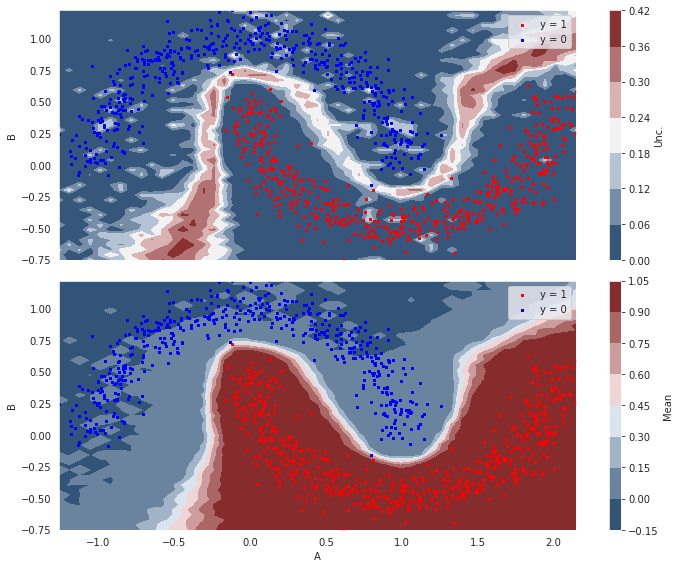

In [9]:
plot_contour(homo_model, x_test, y_test, getFunction = getMeanStd)


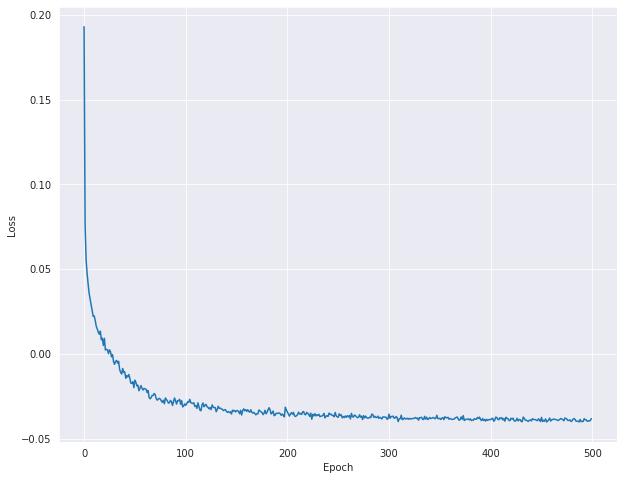

In [15]:
plot_loss(homo_model_h)

# Contour for heteroscedatic Gaussian-prior BNN model

In [10]:
#plot_contour(hetero_model_bnn, x_test, y_test, getFunction = getMeanStdBNN)


# Contour for homoscedatic Gaussian-prior BNN model

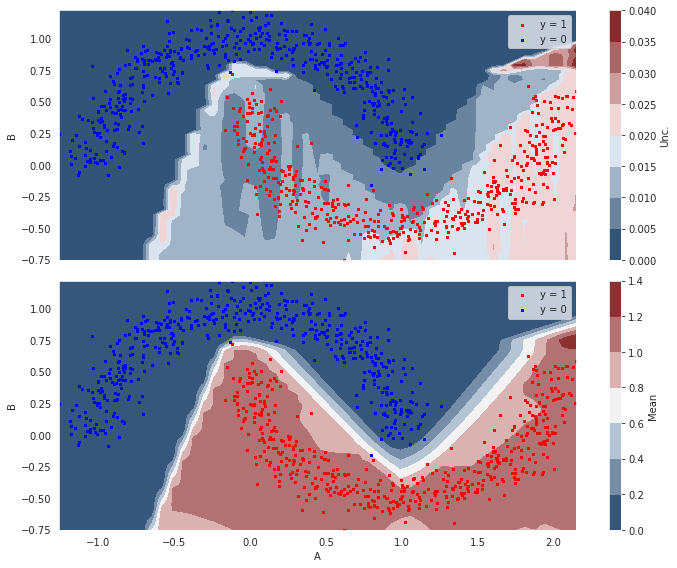

In [11]:
plot_contour(homo_model_bnn, x_test, y_test, getFunction = getMeanStdBNN)


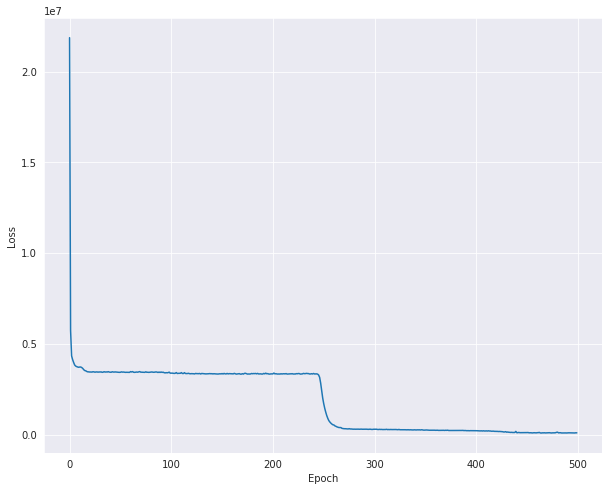

In [16]:
plot_loss(homo_model_bnn_h)